In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [4]:
columns,data=read_data("../input/train_test_ext.npy.npz")
len(columns),data.shape

(1, 829, 517) (59, 829, 517)


(67, (829, 517, 67))

In [5]:
gc.collect()

15

In [6]:
#show_data(data,columns, 1,480, None)

In [7]:
#show_data2(data,columns)

# cv

In [8]:
n_reg_lookback=28

In [9]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [10]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [11]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [12]:
def make_ondate_train_test(ondate_cols):
    ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
    ondate_train_test=normalize(ondate_train_test)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'weekday6', 'holiday', 'TMAX']+
                  ['store_nan_week_ratio', 'store_y1_week_ratio', 'store_y2_week_ratio', 'store_y4_week_ratio', 'store_y4_week_ratio'])
len(ondate_cols)

10

In [14]:
def make_lag_train_test(lag_cols):
    lag_train_test=data[:,:,get_index(lag_cols)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [16]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [17]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [18]:
import cPickle as pickle
indexes=[pickle.load(open(u)) for  u in ['train_idx_1.pkl','train_idx_2.pkl','train_idx_3.pkl']]

In [19]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [20]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print df2['error2'].mean()
    return  df2['error2'].mean()
def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=478)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [23]:
reload(rrvf)
import rrvf_data
def _run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset,rawy):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols)
    lag_train_test = make_lag_train_test(lag_cols)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478, # 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testconv", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=True,use_dropout=False,model_type="conv",
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    train_loss,trainy,trainpred,trainidx=a.eval_train()
    print valid_loss,train_loss
    
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),(trainy,trainidx,trainpred),pred478



def run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset,rawy):
    while 1:
        ret=_run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset,rawy)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [24]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [25]:
j=0
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    _,validpred,trainpred,pred478=run_once(indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1,rawy=rawy)
    validpreds[offset]=[validpred,trainpred,pred478]
    pickle.dump(validpreds, open('conv_bn_valid{}_preds.pkl'.format(j),'wb'))



1
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1688
0
26 10 (1, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1686/1688 [============================>.] - ETA: 0s - loss: 4.7070 - total_loss: 4.7070 - reg_loss: 4.7070Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 22s 13ms/step - loss: 4.7036 - total_loss: 4.7036 - reg_loss: 4.7036 - val_loss: 2.0443 - val_total_loss: 2.0443 - val_reg_loss: 2.0443
best_epochs [1]
individual loss [ 2.04465523]
[ 1.] 2.044655225
bad init,try again.
(10,) 0.0169891 19.316
(829, 517, 10)
(82

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.861001  0.068109  0.255153    7  2017-04-16
472     2.507290  2.591645 -0.084355  0.247879    1  2017-04-17
473     2.661330  2.654965  0.006365  0.269198    2  2017-04-18
474     2.754815  2.775974 -0.021159  0.223564    3  2017-04-19
475     2.713762  2.789998 -0.076236  0.258962    4  2017-04-20
476     2.999000  2.973073  0.025926  0.168315    5  2017-04-21
477     3.075529  3.101047 -0.025518  0.197805    6  2017-04-22

0.231553850776
best_epochs [7, 10, 4, 8, 11]
(829, 1) 2.70224357724 

2
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1688
0
26 10 (2, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1685/1688 [============================>.] - ETA: 0s - loss: 4.8065 - total_loss: 4.8065 - reg_loss: 4.8065Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 21s 12ms/step - loss: 4.8015 - total_loss: 4.8015 - reg_loss: 4.8015 - val_loss: 2.0877 - val_total_loss: 2.0877 - val_reg_loss: 2.0877
best_epochs [1]
individual loss [ 2.08666818]
[ 1.] 2.086

{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1684/1688 [============================>.] - ETA: 0s - loss: 4.8176 - total_loss: 4.8176 - reg_loss: 4.8176Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 21s 12ms/step - loss: 4.8107 - total_loss: 4.8107 - reg_loss: 4.8107 - val_loss: 2.0867 - val_total_loss: 2.0867 - val_reg_loss: 2.0867
best_epochs [1]
individual loss [ 2.08657492]
[ 1.] 2.08657491985
bad init,try again.
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1688
0
26 10 (2, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer':

best_epochs [1]
individual loss [ 2.08705402]
[ 1.] 2.08705401504
bad init,try again.
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1688
0
26 10 (2, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1685/1688 [============================>.] - ETA: 0s - loss: 4.8073 - total_loss: 4.8073 - reg_loss: 4.8073Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.8021 - total_loss: 4.8021 - reg_loss: 4.8021 - val_loss: 2.0854 - val_total_loss: 2.0854 - val_reg_loss: 2.0854
best_epochs [1]
individual loss [ 2.0863779

Epoch 9/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519 - val_loss: 0.2380 - val_total_loss: 0.2380 - val_reg_loss: 0.2380
Epoch 10/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503 - val_loss: 0.2364 - val_total_loss: 0.2364 - val_reg_loss: 0.2364
Epoch 11/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481 - val_loss: 0.2391 - val_total_loss: 0.2391 - val_reg_loss: 0.2391
Epoch 12/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464 - val_loss: 0.2331 - val_total_loss: 0.2331 - val_reg_loss: 0.2331
Epoch 13/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448 - val_loss: 0.2390 - val_total_loss: 0.2390 - val_reg_loss: 0.2390
Epoch 14/100
1688/1688 [=======

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.871731  0.057379  0.249638    6  2017-04-15
471     2.507290  2.567970 -0.060679  0.244939    7  2017-04-16
472     2.661330  2.674951 -0.013621  0.271978    1  2017-04-17
473     2.754815  2.770930 -0.016115  0.227854    2  2017-04-18
474     2.713762  2.773941 -0.060180  0.257169    3  2017-04-19
475     2.999000  2.992265  0.006735  0.167622    4  2017-04-20
476     3.075529  3.106105 -0.030576  0.201581    5  2017-04-21

0.231540193888
best_epochs [14, 12, 16, 18, 8]
(829, 1) 2.48149250909 

3
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1688
0
26 10 (3, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.3966 - total_loss: 0.3966 - reg_loss: 0.3966 - val_loss: 0.2979 - val_total_loss: 0.2979 - val_reg_loss: 0.2979
Epoch 2/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2807 - total_loss: 0.2807 - reg_loss: 0.2807 - val_loss: 0.2526 - val_total_loss: 0.2526 - val_reg_loss: 0.2526
Epoch 3/100
1688/1688 [==============================] - 20s 12ms/ste

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.846243  0.082867  0.250470    5  2017-04-14
470     2.507290  2.576636 -0.069346  0.248236    6  2017-04-15
471     2.661330  2.651747  0.009583  0.266960    7  2017-04-16
472     2.754815  2.755334 -0.000519  0.224349    1  2017-04-17
473     2.713762  2.743672 -0.029910  0.255507    2  2017-04-18
474     2.999000  2.993977  0.005022  0.166595    3  2017-04-19
475     3.075529  3.106630 -0.031101  0.199801    4  2017-04-20

0.230273938038
best_epochs [11, 16, 14, 12, 13]
(829, 1) 2.57355388814 

4
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 8290 records out of 8290 records
no valid set
1688
0
26 10 (4, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1683/1688 [============================>.] - ETA: 0s - loss: 5.0510 - total_loss: 5.0510 - reg_loss: 5.0510Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 5.0418 - total_loss: 5.0418 - reg_loss: 5.0418 - val_loss: 2.0465 - val_total_loss: 2.0465 - val_reg_loss: 2.0465
best_epochs [1]
individual loss [ 2.04583134]
[ 1.] 2.

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.859829  0.069281  0.254468    4  2017-04-13
469     2.507290  2.580123 -0.072833  0.245008    5  2017-04-14
470     2.661330  2.637820  0.023510  0.269978    6  2017-04-15
471     2.754815  2.764563 -0.009748  0.225292    7  2017-04-16
472     2.713762  2.770556 -0.056794  0.258228    1  2017-04-17
473     2.999000  2.976279  0.022721  0.169593    2  2017-04-18
474     3.075529  3.101765 -0.026235  0.199890    3  2017-04-19

0.231779577235
best_epochs [9, 12, 7, 10, 6]
(829, 1) 2.67901672204 

5
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1688
0
26 10 (5, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1687/1688 [============================>.] - ETA: 0s - loss: 33.0511 - total_loss: 33.0511 - reg_loss: 33.0511Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 33.0328 - total_loss: 33.0328 - reg_loss: 33.0328 - val_loss: 2.0397 - val_total_loss: 2.0397 - val_reg_loss: 2.0397
best_epochs [1]
individual loss [ 2.03748969]
[ 1.]

Epoch 1/100
1683/1688 [============================>.] - ETA: 0s - loss: 4.7271 - total_loss: 4.7271 - reg_loss: 4.7271Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.7187 - total_loss: 4.7187 - reg_loss: 4.7187 - val_loss: 2.0187 - val_total_loss: 2.0187 - val_reg_loss: 2.0187
best_epochs [1]
individual loss [ 2.01968388]
[ 1.] 2.01968388482
bad init,try again.
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1688
0
26 10 (5, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1686/1688 [====================

rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1688
0
26 10 (5, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1687/1688 [============================>.] - ETA: 0s - loss: 7.8506 - total_loss: 7.8506 - reg_loss: 7.8506Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 7.8471 - total_loss: 7.8471 - reg_loss: 7.8471 - val_loss: 2.0387 - val_total_loss: 2.0387 - val_reg_loss: 2.0387
best_epochs [1]
individual loss [ 2.03761489]
[ 1.] 2.03761489036
bad init,try again.
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 rec

1688/1688 [==============================] - 20s 12ms/step - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689 - val_loss: 0.2437 - val_total_loss: 0.2437 - val_reg_loss: 0.2437
Epoch 5/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658 - val_loss: 0.2536 - val_total_loss: 0.2536 - val_reg_loss: 0.2536
Epoch 6/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640 - val_loss: 0.2468 - val_total_loss: 0.2468 - val_reg_loss: 0.2468
Epoch 7/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621 - val_loss: 0.2441 - val_total_loss: 0.2441 - val_reg_loss: 0.2441
Epoch 8/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602 - val_loss: 0.2404 - val_total_loss: 0.2404 - val_reg_loss: 0.2404
Epoch 9/100
1688/1688 [========================

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.878025  0.051085  0.247702    3  2017-04-12
468     2.507290  2.603482 -0.096191  0.248747    4  2017-04-13
469     2.661330  2.648722  0.012608  0.266552    5  2017-04-14
470     2.754815  2.742669  0.012146  0.223063    6  2017-04-15
471     2.713762  2.723892 -0.010130  0.250110    7  2017-04-16
472     2.999000  2.975075  0.023925  0.171389    1  2017-04-17
473     3.075529  3.101091 -0.025562  0.195622    2  2017-04-18

0.229026222257
best_epochs [9, 12, 8, 11, 10]
(829, 1) 2.67733784722 

6
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 9948 records out of 9948 records
no valid set
1688
0
26 10 (6, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1686/1688 [============================>.] - ETA: 0s - loss: 1.5831 - total_loss: 1.5831 - reg_loss: 1.5831Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 1.5816 - total_loss: 1.5816 - reg_loss: 1.5816 - val_loss: 0.2630 - val_total_loss: 0.2630 - val_reg_loss: 0.2630
best_epochs [1]
individual loss [ 0.26313706]
[ 1.] 0.26

1688/1688 [==============================] - 20s 12ms/step - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647 - val_loss: 0.2477 - val_total_loss: 0.2477 - val_reg_loss: 0.2477
Epoch 7/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625 - val_loss: 0.2485 - val_total_loss: 0.2485 - val_reg_loss: 0.2485
Epoch 8/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617 - val_loss: 0.2493 - val_total_loss: 0.2493 - val_reg_loss: 0.2493
best_epochs [3, 5, 2, 6, 7]
individual loss [ 0.24335167  0.24374061  0.24768778  0.24841954  0.24823543]
[ 0.07847982  0.46462844  0.15596154  0.04764418  0.25328602] 0.237559194305
best_epochs [3, 5, 2, 6, 7]
0.23755919436 0.23755919436
(1, 0.23755919435982609)
best_epochs [3, 5, 2, 6, 7]
0.255569756231 0.255569756231
(1, 0.25556975623104311)
0.23755919436 0.255569756231
best_epochs [3, 5, 2, 6, 7]
(9948, 1) 2.66362005049 (9948

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.853568  0.075542  0.254810    2  2017-04-11
467     2.507290  2.574748 -0.067457  0.248063    3  2017-04-12
468     2.661330  2.604090  0.057240  0.275218    4  2017-04-13
469     2.754815  2.708420  0.046395  0.223740    5  2017-04-14
470     2.713762  2.698682  0.015079  0.254650    6  2017-04-15
471     2.999000  2.962232  0.036768  0.171480    7  2017-04-16
472     3.075529  3.089652 -0.014123  0.201860    1  2017-04-17

0.232831531989
best_epochs [3, 5, 2, 6, 7]
(829, 1) 2.95045395088 

7
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 10777 records out of 10777 records
no valid set
1688
0
26 10 (7, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.8394 - total_loss: 0.8394 - reg_loss: 0.8394 - val_loss: 0.2650 - val_total_loss: 0.2650 - val_reg_loss: 0.2650
Epoch 2/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2782 - total_loss: 0.2782 - reg_loss: 0.2782 - val_loss: 0.2462 - val_total_loss: 0.2462 - val_reg_loss: 0.2462
Epoch 3/100
1688/1688 [==============================] - 20s 12ms/step 

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.842144  0.086966  0.253469    1  2017-04-10
466     2.507290  2.581270 -0.073979  0.245809    2  2017-04-11
467     2.661330  2.618837  0.042493  0.270891    3  2017-04-12
468     2.754815  2.727751  0.027063  0.220423    4  2017-04-13
469     2.713762  2.723185 -0.009423  0.249871    5  2017-04-14
470     2.999000  2.952121  0.046879  0.171481    6  2017-04-15
471     3.075529  3.082905 -0.007376  0.196575    7  2017-04-16

0.22978820788
best_epochs [7, 9, 12, 10, 11]
(829, 1) 3.01664310608 

8
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 11606 records out of 11606 records
no valid set
1688
0
26 10 (8, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1687/1688 [============================>.] - ETA: 0s - loss: 4.8273 - total_loss: 4.8273 - reg_loss: 4.8273Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.8255 - total_loss: 4.8255 - reg_loss: 4.8255 - val_loss: 2.1047 - val_total_loss: 2.1047 - val_reg_loss: 2.1047
best_epochs [1]
individual loss [ 2.10438713]
[ 1.] 2.1

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.901817  0.027293  0.248236    7  2017-04-09
465     2.507290  2.593494 -0.086203  0.249742    1  2017-04-10
466     2.661330  2.652041  0.009288  0.270746    2  2017-04-11
467     2.754815  2.740168  0.014647  0.227751    3  2017-04-12
468     2.713762  2.750749 -0.036987  0.249668    4  2017-04-13
469     2.999000  2.978335  0.020664  0.169061    5  2017-04-14
470     3.075529  3.126438 -0.050908  0.197156    6  2017-04-15

0.230337259792
best_epochs [11, 13, 15, 14, 9]
(829, 1) 2.68304914539 

9
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 12435 records out of 12435 records
no valid set
1688
0
26 10 (9, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1683/1688 [============================>.] - ETA: 0s - loss: 4.8334 - total_loss: 4.8334 - reg_loss: 4.8334Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.8247 - total_loss: 4.8247 - reg_loss: 4.8247 - val_loss: 2.0963 - val_total_loss: 2.0963 - val_reg_loss: 2.0963
best_epochs [1]
individual loss [ 2.09617562]
[ 1.] 2

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.892978  0.036132  0.246236    6  2017-04-08
464     2.507290  2.601277 -0.093987  0.250967    7  2017-04-09
465     2.661330  2.667287 -0.005958  0.271201    1  2017-04-10
466     2.754815  2.766026 -0.011211  0.227085    2  2017-04-11
467     2.713762  2.755656 -0.041894  0.252344    3  2017-04-12
468     2.999000  2.971712  0.027288  0.169291    4  2017-04-13
469     3.075529  3.108472 -0.032942  0.193814    5  2017-04-14

0.230133840086
best_epochs [9, 11, 7, 13, 6]
(829, 1) 2.48777895994 

10
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 13264 records out of 13264 records
no valid set
1688
0
26 10 (10, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.4124 - total_loss: 0.4124 - reg_loss: 0.4124 - val_loss: 0.3447 - val_total_loss: 0.3447 - val_reg_loss: 0.3447
Epoch 2/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2947 - total_loss: 0.2947 - reg_loss: 0.2947 - val_loss: 0.2812 - val_total_loss: 0.2812 - val_reg_loss: 0.2812
Epoch 3/100
1688/1688 [==============================] - 20s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.887437  0.041673  0.248011    5  2017-04-07
463     2.507290  2.579892 -0.072602  0.244445    6  2017-04-08
464     2.661330  2.644300  0.017030  0.270542    7  2017-04-09
465     2.754815  2.732203  0.022612  0.227619    1  2017-04-10
466     2.713762  2.716342 -0.002580  0.250207    2  2017-04-11
467     2.999000  2.925294  0.073706  0.172629    3  2017-04-12
468     3.075529  3.063151  0.012378  0.189867    4  2017-04-13

0.2290455554
best_epochs [13, 12, 16, 14, 17]
(829, 1) 2.57828007878 

11
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1688
0
26 10 (11, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1685/1688 [============================>.] - ETA: 0s - loss: 4.7515 - total_loss: 4.7515 - reg_loss: 4.7515Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.7466 - total_loss: 4.7466 - reg_loss: 4.7466 - val_loss: 2.0339 - val_total_loss: 2.0339 - val_reg_loss: 2.0339
best_epochs [1]
individual loss [ 2.03331539]
[ 1.] 

Epoch 1/100
1684/1688 [============================>.] - ETA: 0s - loss: 4.7535 - total_loss: 4.7535 - reg_loss: 4.7535Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.7468 - total_loss: 4.7468 - reg_loss: 4.7468 - val_loss: 2.0335 - val_total_loss: 2.0335 - val_reg_loss: 2.0335
best_epochs [1]
individual loss [ 2.03331952]
[ 1.] 2.03331951993
bad init,try again.
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1688
0
26 10 (11, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1688/1688 [=================

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.900488  0.028622  0.250103    4  2017-04-06
462     2.507290  2.602802 -0.095511  0.250568    5  2017-04-07
463     2.661330  2.665344 -0.004014  0.272562    6  2017-04-08
464     2.754815  2.748533  0.006282  0.227390    7  2017-04-09
465     2.713762  2.739429 -0.025668  0.254400    1  2017-04-10
466     2.999000  2.959203  0.039797  0.173784    2  2017-04-11
467     3.075529  3.090389 -0.014860  0.198592    3  2017-04-12

0.23248571418
best_epochs [7, 4, 11, 9, 10]
(829, 1) 2.94669577246 

12
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 14922 records out of 14922 records
no valid set
1688
0
26 10 (12, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1687/1688 [============================>.] - ETA: 0s - loss: 5.1986 - total_loss: 5.1986 - reg_loss: 5.1986Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 5.1966 - total_loss: 5.1966 - reg_loss: 5.1966 - val_loss: 2.0308 - val_total_loss: 2.0308 - val_reg_loss: 2.0308
best_epochs [1]
individual loss [ 2.03074527]
[ 1.] 2.

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.867121  0.061989  0.259503    3  2017-04-05
461     2.507290  2.596895 -0.089605  0.247269    4  2017-04-06
462     2.661330  2.639840  0.021490  0.272798    5  2017-04-07
463     2.754815  2.719914  0.034900  0.226329    6  2017-04-08
464     2.713762  2.689114  0.024647  0.253773    7  2017-04-09
465     2.999000  2.910141  0.088859  0.181412    1  2017-04-10
466     3.075529  3.050561  0.024968  0.201603    2  2017-04-11

0.234669642965
best_epochs [11, 10, 13, 9, 12]
(829, 1) 2.95069772458 

13
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 15751 records out of 15751 records
no valid set
1688
0
26 10 (13, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1687/1688 [============================>.] - ETA: 0s - loss: 4.6922 - total_loss: 4.6922 - reg_loss: 4.6922Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.6907 - total_loss: 4.6907 - reg_loss: 4.6907 - val_loss: 2.0124 - val_total_loss: 2.0124 - val_reg_loss: 2.0124
best_epochs [1]
individual loss [ 2.01485097]
[ 1.]

1688/1688 [==============================] - 20s 12ms/step - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567 - val_loss: 0.2444 - val_total_loss: 0.2444 - val_reg_loss: 0.2444
Epoch 18/100
1688/1688 [==============================] - 19s 11ms/step - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553 - val_loss: 0.2470 - val_total_loss: 0.2470 - val_reg_loss: 0.2470
Epoch 19/100
1688/1688 [==============================] - 19s 12ms/step - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537 - val_loss: 0.2448 - val_total_loss: 0.2448 - val_reg_loss: 0.2448
best_epochs [14, 15, 11, 8, 9]
individual loss [ 0.24155169  0.24406266  0.2426361   0.245179    0.24234997]
[  2.44403397e-01   2.49752028e-01   3.13998405e-01  -8.67361738e-19
   1.91846169e-01] 0.238283151935
best_epochs [14, 15, 11, 8, 9]
0.238283151866 0.238283151866
(1, 0.23828315186599797)
best_epochs [14, 15, 11, 8, 9]
0.253057979206 0.253057979206
(1, 0.25305797920613432)
0.238283151866 0.253057979206
best_epochs [14, 

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.855910  0.073199  0.254890    2  2017-04-04
460     2.507290  2.568974 -0.061684  0.242414    3  2017-04-05
461     2.661330  2.623306  0.038024  0.268825    4  2017-04-06
462     2.754815  2.716192  0.038623  0.225676    5  2017-04-07
463     2.713762  2.695110  0.018652  0.253487    6  2017-04-08
464     2.999000  2.929103  0.069896  0.171873    7  2017-04-09
465     3.075529  3.071636  0.003893  0.193458    1  2017-04-10

0.230088958788
best_epochs [14, 15, 11, 8, 9]
(829, 1) 3.01406268317 

14
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 16580 records out of 16580 records
no valid set
1688
0
26 10 (14, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1685/1688 [============================>.] - ETA: 0s - loss: 4.7638 - total_loss: 4.7638 - reg_loss: 4.7638Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.7584 - total_loss: 4.7584 - reg_loss: 4.7584 - val_loss: 2.0583 - val_total_loss: 2.0583 - val_reg_loss: 2.0583
best_epochs [1]
individual loss [ 2.05824842]
[ 1.] 

1688/1688 [==============================] - 20s 12ms/step - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673 - val_loss: 0.2428 - val_total_loss: 0.2428 - val_reg_loss: 0.2428
Epoch 7/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650 - val_loss: 0.2591 - val_total_loss: 0.2591 - val_reg_loss: 0.2591
Epoch 8/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632 - val_loss: 0.2440 - val_total_loss: 0.2440 - val_reg_loss: 0.2440
Epoch 9/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617 - val_loss: 0.2467 - val_total_loss: 0.2467 - val_reg_loss: 0.2467
Epoch 10/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604 - val_loss: 0.2409 - val_total_loss: 0.2409 - val_reg_loss: 0.2409
Epoch 11/100
1688/1688 [======================

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.865416  0.063694  0.257565    1  2017-04-03
459     2.507290  2.580072 -0.072781  0.242371    2  2017-04-04
460     2.661330  2.634532  0.026797  0.271101    3  2017-04-05
461     2.754815  2.713199  0.041616  0.224647    4  2017-04-06
462     2.713762  2.690518  0.023244  0.244488    5  2017-04-07
463     2.999000  2.946136  0.052864  0.170843    6  2017-04-08
464     3.075529  3.074504  0.001025  0.194536    7  2017-04-09

0.229364535538
best_epochs [11, 15, 10, 16, 12]
(829, 1) 3.03758175052 

15
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1688
0
26 10 (15, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1686/1688 [============================>.] - ETA: 0s - loss: 4.8163 - total_loss: 4.8163 - reg_loss: 4.8163Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.8128 - total_loss: 4.8128 - reg_loss: 4.8128 - val_loss: 2.0965 - val_total_loss: 2.0965 - val_reg_loss: 2.0965
best_epochs [1]
individual loss [ 2.09644302]
[ 1.

Epoch 1/100
1686/1688 [============================>.] - ETA: 0s - loss: 12.0613 - total_loss: 12.0613 - reg_loss: 12.0613Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 12.0493 - total_loss: 12.0493 - reg_loss: 12.0493 - val_loss: 2.1148 - val_total_loss: 2.1148 - val_reg_loss: 2.1148
best_epochs [1]
individual loss [ 2.11503869]
[ 1.] 2.11503868701
bad init,try again.
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1688
0
26 10 (15, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1687/1688 [===========

(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1688
0
26 10 (15, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.6995 - total_loss: 0.6995 - reg_loss: 0.6995 - val_loss: 0.2777 - val_total_loss: 0.2777 - val_reg_loss: 0.2777
Epoch 2/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2761 - total_loss: 0.2761 - reg_loss: 0.2761 - val_loss: 0.2487 - val_total_loss: 0.2487 - val_reg_loss: 0.2487
Epoch 3/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706 - val_loss: 0.2422 - val_total_loss: 0.2422 - val_re

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.905246  0.023864  0.257848    7  2017-04-02
458     2.507290  2.589945 -0.082654  0.249581    1  2017-04-03
459     2.661330  2.675526 -0.014196  0.272710    2  2017-04-04
460     2.754815  2.756741 -0.001926  0.222425    3  2017-04-05
461     2.713762  2.735430 -0.021668  0.256737    4  2017-04-06
462     2.999000  2.970420  0.028579  0.173198    5  2017-04-07
463     3.075529  3.101410 -0.025881  0.194688    6  2017-04-08

0.232455458738
best_epochs [12, 9, 17, 14, 7]
(829, 1) 2.70167407458 

16
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 18238 records out of 18238 records
no valid set
1688
0
26 10 (16, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1686/1688 [============================>.] - ETA: 0s - loss: 4.8135 - total_loss: 4.8135 - reg_loss: 4.8135Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.8102 - total_loss: 4.8102 - reg_loss: 4.8102 - val_loss: 2.0861 - val_total_loss: 2.0861 - val_reg_loss: 2.0861
best_epochs [1]
individual loss [ 2.08639882]
[ 1.] 

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.847652  0.081458  0.258951    6  2017-04-01
457     2.507290  2.560621 -0.053330  0.239576    7  2017-04-02
458     2.661330  2.604149  0.057180  0.273987    1  2017-04-03
459     2.754815  2.680657  0.074157  0.228259    2  2017-04-04
460     2.713762  2.673326  0.040435  0.258383    3  2017-04-05
461     2.999000  2.915192  0.083808  0.178623    4  2017-04-06
462     3.075529  3.068604  0.006925  0.195888    5  2017-04-07

0.233381020207
best_epochs [12, 15, 14, 7, 17]
(829, 1) 2.4736640388 

17
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 19067 records out of 19067 records
no valid set
1688
0
26 10 (17, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1686/1688 [============================>.] - ETA: 0s - loss: 4.8791 - total_loss: 4.8791 - reg_loss: 4.8791Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.8755 - total_loss: 4.8755 - reg_loss: 4.8755 - val_loss: 2.0763 - val_total_loss: 2.0763 - val_reg_loss: 2.0763
best_epochs [1]
individual loss [ 2.07656064]
[ 1.] 

best_epochs [10, 7, 14, 11, 8]
(19067, 1) 2.71605407232 (19067, 2)


y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.879165  0.049945  0.255471    5  2017-03-31
456     2.507290  2.574008 -0.066718  0.244429    6  2017-04-01
457     2.661330  2.644339  0.016991  0.270413    7  2017-04-02
458     2.754815  2.712413  0.042402  0.224800    1  2017-04-03
459     2.713762  2.703143  0.010619  0.258301    2  2017-04-04
460     2.999000  2.929600  0.069400  0.181656    3  2017-04-05
461     3.075529  3.071834  0.003695  0.194535    4  2017-04-06

0.232800603685
best_epochs [10, 7, 14, 11, 8]
(829, 1) 2.58741626894 

18
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1688
0
26 10 (18, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1683/1688 [============================>.] - ETA: 0s - loss: 8.0232 - total_loss: 8.0232 - reg_loss: 8.0232Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 8.0052 - total_loss: 8.0052 - reg_loss: 8.0052 - val_loss: 2.0520 - val_total_loss: 2.0520 - val_reg_loss: 2.0520
best_epochs [1]
individual loss [ 2.05167958]
[ 1.] 

Epoch 1/100
1683/1688 [============================>.] - ETA: 0s - loss: 4.9117 - total_loss: 4.9117 - reg_loss: 4.9117Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.9027 - total_loss: 4.9027 - reg_loss: 4.9027 - val_loss: 2.0318 - val_total_loss: 2.0318 - val_reg_loss: 2.0318
best_epochs [1]
individual loss [ 2.0332008]
[ 1.] 2.03320079897
bad init,try again.
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1688
0
26 10 (18, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1683/1688 [==================

Epoch 19/100
1688/1688 [==============================] - 19s 12ms/step - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514 - val_loss: 0.2457 - val_total_loss: 0.2457 - val_reg_loss: 0.2457
Epoch 20/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496 - val_loss: 0.2619 - val_total_loss: 0.2619 - val_reg_loss: 0.2619
Epoch 21/100
1688/1688 [==============================] - 19s 12ms/step - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479 - val_loss: 0.2485 - val_total_loss: 0.2485 - val_reg_loss: 0.2485
best_epochs [16, 13, 10, 9, 11]
individual loss [ 0.24784341  0.24601449  0.245811    0.24537926  0.24393029]
[ 0.14646035  0.05696452  0.30943099  0.1543266   0.33281754] 0.238957168543
best_epochs [16, 13, 10, 9, 11]
0.238957168537 0.238957168537
(1, 0.23895716853697022)
best_epochs [16, 13, 10, 9, 11]
0.253456993505 0.253456993505
(1, 0.25345699350543488)
0.238957168537 0.253456993505
best_epochs [16, 13, 10, 9,

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.887594  0.041516  0.258708    4  2017-03-30
455     2.507290  2.595006 -0.087715  0.249605    5  2017-03-31
456     2.661330  2.648713  0.012616  0.276071    6  2017-04-01
457     2.754815  2.727746  0.027069  0.230389    7  2017-04-02
458     2.713762  2.730780 -0.017019  0.263511    1  2017-04-03
459     2.999000  2.937144  0.061855  0.180357    2  2017-04-04
460     3.075529  3.063530  0.012000  0.196939    3  2017-04-05

0.23651142461
best_epochs [16, 13, 10, 9, 11]
(829, 1) 2.68732005601 

19
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 20725 records out of 20725 records
no valid set
1688
0
26 10 (19, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.3829 - total_loss: 0.3829 - reg_loss: 0.3829 - val_loss: 0.2613 - val_total_loss: 0.2613 - val_reg_loss: 0.2613
Epoch 2/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2873 - total_loss: 0.2873 - reg_loss: 0.2873 - val_loss: 0.2528 - val_total_loss: 0.2528 - val_reg_loss: 0.2528
Epoch 3/100
1688/1688 [==============================] - 20s 12ms/

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.915177  0.013933  0.262038    3  2017-03-29
454     2.507290  2.565342 -0.058051  0.246869    4  2017-03-30
455     2.661330  2.651326  0.010004  0.279346    5  2017-03-31
456     2.754815  2.738479  0.016336  0.227178    6  2017-04-01
457     2.713762  2.710448  0.003314  0.265195    7  2017-04-02
458     2.999000  2.960432  0.038568  0.180881    1  2017-04-03
459     3.075529  3.076647 -0.001118  0.194206    2  2017-04-04

0.236530448021
best_epochs [14, 12, 10, 11, 8]
(829, 1) 2.67030786615 

20
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 21554 records out of 21554 records
no valid set
1688
0
26 10 (20, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1687/1688 [============================>.] - ETA: 0s - loss: 80.0060 - total_loss: 80.0060 - reg_loss: 80.0060Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 79.9597 - total_loss: 79.9597 - reg_loss: 79.9597 - val_loss: 2.0289 - val_total_loss: 2.0289 - val_reg_loss: 2.0289
best_epochs [1]
individual loss [ 2.0289823]


y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.897236  0.031874  0.257872    2  2017-03-28
453     2.507290  2.584978 -0.077688  0.253213    3  2017-03-29
454     2.661330  2.621603  0.039727  0.277624    4  2017-03-30
455     2.754815  2.727990  0.026824  0.231524    5  2017-03-31
456     2.713762  2.743749 -0.029987  0.265273    6  2017-04-01
457     2.999000  2.938897  0.060103  0.183611    7  2017-04-02
458     3.075529  3.062787  0.012743  0.198776    1  2017-04-03

0.238270383481
best_epochs [7, 12, 9, 10, 11]
(829, 1) 2.89540134704 

21
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 22383 records out of 22383 records
no valid set
1688
0
26 10 (21, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1686/1688 [============================>.] - ETA: 0s - loss: 1.4747 - total_loss: 1.4747 - reg_loss: 1.4747Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 1.4733 - total_loss: 1.4733 - reg_loss: 1.4733 - val_loss: 0.2866 - val_total_loss: 0.2866 - val_reg_loss: 0.2866
best_epochs [1]
individual loss [ 0.28658151]
[ 1.] 

1688/1688 [==============================] - 20s 12ms/step - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670 - val_loss: 0.2411 - val_total_loss: 0.2411 - val_reg_loss: 0.2411
Epoch 7/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649 - val_loss: 0.2425 - val_total_loss: 0.2425 - val_reg_loss: 0.2425
Epoch 8/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632 - val_loss: 0.2462 - val_total_loss: 0.2462 - val_reg_loss: 0.2462
Epoch 9/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609 - val_loss: 0.2431 - val_total_loss: 0.2431 - val_reg_loss: 0.2431
Epoch 10/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593 - val_loss: 0.2507 - val_total_loss: 0.2507 - val_reg_loss: 0.2507
Epoch 11/100
1688/1688 [======================

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.880295  0.048815  0.263539    1  2017-03-27
452     2.507290  2.581107 -0.073816  0.242374    2  2017-03-28
453     2.661330  2.645666  0.015664  0.273631    3  2017-03-29
454     2.754815  2.723674  0.031141  0.229445    4  2017-03-30
455     2.713762  2.745651 -0.031890  0.260922    5  2017-03-31
456     2.999000  2.934063  0.064937  0.178857    6  2017-04-01
457     3.075529  3.056219  0.019311  0.197504    7  2017-04-02

0.235181751332
best_epochs [15, 13, 11, 19, 16]
(829, 1) 3.03330206743 

22
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1688
0
26 10 (22, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1687/1688 [============================>.] - ETA: 0s - loss: 4.8040 - total_loss: 4.8040 - reg_loss: 4.8040Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.8025 - total_loss: 4.8025 - reg_loss: 4.8025 - val_loss: 2.0973 - val_total_loss: 2.0973 - val_reg_loss: 2.0973
best_epochs [1]
individual loss [ 2.09708435]
[ 1.

Epoch 1/100
1685/1688 [============================>.] - ETA: 0s - loss: 4.8054 - total_loss: 4.8054 - reg_loss: 4.8054Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.8001 - total_loss: 4.8001 - reg_loss: 4.8001 - val_loss: 2.0956 - val_total_loss: 2.0956 - val_reg_loss: 2.0956
best_epochs [1]
individual loss [ 2.09668124]
[ 1.] 2.09668123548
bad init,try again.
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1688
0
26 10 (22, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1685/1688 [=================

Epoch 3/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2716 - total_loss: 0.2716 - reg_loss: 0.2716 - val_loss: 0.2585 - val_total_loss: 0.2585 - val_reg_loss: 0.2585
Epoch 4/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688 - val_loss: 0.2425 - val_total_loss: 0.2425 - val_reg_loss: 0.2425
Epoch 5/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657 - val_loss: 0.2369 - val_total_loss: 0.2369 - val_reg_loss: 0.2369
Epoch 6/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642 - val_loss: 0.2340 - val_total_loss: 0.2340 - val_reg_loss: 0.2340
Epoch 7/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617 - val_loss: 0.2338 - val_total_loss: 0.2338 - val_reg_loss: 0.2338
Epoch 8/100
1688/1688 [============

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.884752  0.044358  0.259376    7  2017-03-26
451     2.507290  2.596788 -0.089497  0.247992    1  2017-03-27
452     2.661330  2.644144  0.017186  0.271791    2  2017-03-28
453     2.754815  2.745454  0.009360  0.230453    3  2017-03-29
454     2.713762  2.733500 -0.019738  0.259190    4  2017-03-30
455     2.999000  2.969775  0.029225  0.179034    5  2017-03-31
456     3.075529  3.088925 -0.013396  0.193630    6  2017-04-01

0.234495014036
best_epochs [11, 16, 13, 15, 7]
(829, 1) 2.68014179736 

23
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 24041 records out of 24041 records
no valid set
1688
0
26 10 (23, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1687/1688 [============================>.] - ETA: 0s - loss: 4.8065 - total_loss: 4.8065 - reg_loss: 4.8065Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.8048 - total_loss: 4.8048 - reg_loss: 4.8048 - val_loss: 2.0860 - val_total_loss: 2.0860 - val_reg_loss: 2.0860
best_epochs [1]
individual loss [ 2.08657664]
[ 1.]

Epoch 15/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601 - val_loss: 0.2388 - val_total_loss: 0.2388 - val_reg_loss: 0.2388
best_epochs [10, 15, 11, 13, 7]
individual loss [ 0.24045186  0.24030316  0.24026616  0.24344829  0.24288829]
[ 0.30448403  0.3283204   0.16936465  0.13103676  0.06679417] 0.236391434714
best_epochs [10, 15, 11, 13, 7]
0.236391434764 0.236391434764
(1, 0.23639143476356725)
best_epochs [10, 15, 11, 13, 7]
0.254095480004 0.254095480004
(1, 0.25409548000360765)
0.236391434764 0.254095480004
best_epochs [10, 15, 11, 13, 7]
(24041, 1) 2.74670254067 (24041, 2)


y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.893563  0.035547  0.260301    6  2017-03-25
450     2.507290  2.560975 -0.053685  0.254678    7  2017-03-26
451     2.661330  2.614645  0.046685  0.282317    1  2017-03-27
452     2.754815  2.723583  0.031232  0.232529    2  2017-03-28
453     2.713762  2.716945 -0.003183  0.265413    3  2017-03-29
454     2.999000  2.952153  0.046847  0.183068    4  2017-03-30
455     3.075529  3.104075 -0.028546  0.199539    5  2017-03-31

0.239692115103
best_epochs [10, 15, 11, 13, 7]
(829, 1) 2.49805140235 

24
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 24870 records out of 24870 records
no valid set
1688
0
26 10 (24, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1683/1688 [============================>.] - ETA: 0s - loss: 4.7997 - total_loss: 4.7997 - reg_loss: 4.7997Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.7909 - total_loss: 4.7909 - reg_loss: 4.7909 - val_loss: 2.0608 - val_total_loss: 2.0608 - val_reg_loss: 2.0608
best_epochs [1]
individual loss [ 2.05974953]
[ 1.]

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.903968  0.025142  0.261021    5  2017-03-24
449     2.507290  2.587986 -0.080696  0.252489    6  2017-03-25
450     2.661330  2.642868  0.018462  0.274512    7  2017-03-26
451     2.754815  2.724258  0.030557  0.233523    1  2017-03-27
452     2.713762  2.722101 -0.008340  0.264421    2  2017-03-28
453     2.999000  2.955689  0.043311  0.182684    3  2017-03-29
454     3.075529  3.106268 -0.030739  0.266747    4  2017-03-30

0.247913959079
best_epochs [8, 12, 5, 13, 11]
(829, 1) 2.59814393058 

25
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 25699 records out of 25699 records
no valid set
1688
0
26 10 (25, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.5065 - total_loss: 0.5065 - reg_loss: 0.5065 - val_loss: 0.2886 - val_total_loss: 0.2886 - val_reg_loss: 0.2886
Epoch 2/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2869 - total_loss: 0.2869 - reg_loss: 0.2869 - val_loss: 0.2593 - val_total_loss: 0.2593 - val_reg_loss: 0.2593
Epoch 3/100
1688/1688 [==============================] - 20s 12ms/

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.879791  0.049319  0.258222    4  2017-03-23
448     2.507290  2.583756 -0.076466  0.251591    5  2017-03-24
449     2.661330  2.635186  0.026144  0.273536    6  2017-03-25
450     2.754815  2.707726  0.047089  0.234328    7  2017-03-26
451     2.713762  2.701334  0.012428  0.264959    1  2017-03-27
452     2.999000  2.941141  0.057859  0.184959    2  2017-03-28
453     3.075529  3.059197  0.016332  0.198829    3  2017-03-29

0.238060494493
best_epochs [11, 9, 14, 6, 12]
(829, 1) 2.70568124114 

26
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 26528 records out of 26528 records
no valid set
1688
0
26 10 (26, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1686/1688 [============================>.] - ETA: 0s - loss: 7.3056 - total_loss: 7.3056 - reg_loss: 7.3056Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 7.2973 - total_loss: 7.2973 - reg_loss: 7.2973 - val_loss: 0.2656 - val_total_loss: 0.2656 - val_reg_loss: 0.2656
best_epochs [1]
individual loss [ 0.2654638]
[ 1.] 0

1688/1688 [==============================] - 20s 12ms/step - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584 - val_loss: 0.2464 - val_total_loss: 0.2464 - val_reg_loss: 0.2464
best_epochs [12, 16, 10, 6, 9]
individual loss [ 0.24605499  0.24435446  0.24564107  0.24737955  0.24460175]
[ 0.19345438  0.27282797  0.00758643  0.19895862  0.3271726 ] 0.239630348291
best_epochs [12, 16, 10, 6, 9]
0.239630348277 0.239630348277
(1, 0.23963034827746588)
best_epochs [12, 16, 10, 6, 9]
0.256484161272 0.256484161272
(1, 0.25648416127224744)
0.239630348277 0.256484161272
best_epochs [12, 16, 10, 6, 9]
(26528, 1) 2.72109270538 (26528, 2)


y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.928732  0.000378  0.255679    3  2017-03-22
447     2.507290  2.573684 -0.066393  0.248928    4  2017-03-23
448     2.661330  2.620724  0.040606  0.275878    5  2017-03-24
449     2.754815  2.715092  0.039723  0.230674    6  2017-03-25
450     2.713762  2.729026 -0.015265  0.265277    7  2017-03-26
451     2.999000  2.963540  0.035460  0.184345    1  2017-03-27
452     3.075529  3.086312 -0.010783  0.197249    2  2017-03-28

0.236861516588
best_epochs [12, 16, 10, 6, 9]
(829, 1) 2.68419095535 

27
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1688
0
26 10 (27, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1686/1688 [============================>.] - ETA: 0s - loss: 4.6981 - total_loss: 4.6981 - reg_loss: 4.6981Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.6948 - total_loss: 4.6948 - reg_loss: 4.6948 - val_loss: 2.0177 - val_total_loss: 2.0177 - val_reg_loss: 2.0177
best_epochs [1]
individual loss [ 2.01693068]
[ 1.] 

Epoch 1/100
1686/1688 [============================>.] - ETA: 0s - loss: 4.7575 - total_loss: 4.7575 - reg_loss: 4.7575Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.7539 - total_loss: 4.7539 - reg_loss: 4.7539 - val_loss: 2.0174 - val_total_loss: 2.0174 - val_reg_loss: 2.0174
best_epochs [1]
individual loss [ 2.01792152]
[ 1.] 2.01792151855
bad init,try again.
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1688
0
26 10 (27, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1687/1688 [=================

1688/1688 [==============================] - 20s 12ms/step - loss: 0.2761 - total_loss: 0.2761 - reg_loss: 0.2761 - val_loss: 0.2499 - val_total_loss: 0.2499 - val_reg_loss: 0.2499
Epoch 6/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729 - val_loss: 0.2540 - val_total_loss: 0.2540 - val_reg_loss: 0.2540
Epoch 7/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717 - val_loss: 0.2481 - val_total_loss: 0.2481 - val_reg_loss: 0.2481
Epoch 8/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699 - val_loss: 0.2512 - val_total_loss: 0.2512 - val_reg_loss: 0.2512
Epoch 9/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685 - val_loss: 0.2401 - val_total_loss: 0.2401 - val_reg_loss: 0.2401
Epoch 10/100
1688/1688 [=======================

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.896689  0.032421  0.263109    2  2017-03-21
446     2.507290  2.606388 -0.099098  0.256511    3  2017-03-22
447     2.661330  2.647024  0.014306  0.278240    4  2017-03-23
448     2.754815  2.740229  0.014586  0.233084    5  2017-03-24
449     2.713762  2.739866 -0.026104  0.262202    6  2017-03-25
450     2.999000  2.957499  0.041501  0.183338    7  2017-03-26
451     3.075529  3.103005 -0.027476  0.202493    1  2017-03-27

0.239853893057
best_epochs [9, 12, 14, 7, 5]
(829, 1) 2.93786970963 

28
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 28186 records out of 28186 records
no valid set
1688
0
26 10 (28, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1687/1688 [============================>.] - ETA: 0s - loss: 4.7463 - total_loss: 4.7463 - reg_loss: 4.7463Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.7446 - total_loss: 4.7446 - reg_loss: 4.7446 - val_loss: 2.0511 - val_total_loss: 2.0511 - val_reg_loss: 2.0511
best_epochs [1]
individual loss [ 2.05075131]
[ 1.] 2

Epoch 9/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646 - val_loss: 0.2407 - val_total_loss: 0.2407 - val_reg_loss: 0.2407
Epoch 10/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642 - val_loss: 0.2414 - val_total_loss: 0.2414 - val_reg_loss: 0.2414
Epoch 11/100
1688/1688 [==============================] - 19s 12ms/step - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619 - val_loss: 0.2381 - val_total_loss: 0.2381 - val_reg_loss: 0.2381
Epoch 12/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599 - val_loss: 0.2352 - val_total_loss: 0.2352 - val_reg_loss: 0.2352
Epoch 13/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590 - val_loss: 0.2399 - val_total_loss: 0.2399 - val_reg_loss: 0.2399
Epoch 14/100
1688/1688 [=======

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.901705  0.027405  0.255669    1  2017-03-20
445     2.507290  2.545440 -0.038150  0.238538    2  2017-03-21
446     2.661330  2.620332  0.040998  0.274493    3  2017-03-22
447     2.754815  2.707577  0.047238  0.232230    4  2017-03-23
448     2.713762  2.710903  0.002858  0.260993    5  2017-03-24
449     2.999000  2.976471  0.022529  0.180622    6  2017-03-25
450     3.075529  3.093688 -0.018159  0.201108    7  2017-03-26

0.234807740176
best_epochs [12, 11, 17, 16, 14]
(829, 1) 3.04861392835 

29
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 29015 records out of 29015 records
no valid set
1688
0
26 10 (29, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.7629 - total_loss: 0.7629 - reg_loss: 0.7629 - val_loss: 0.2578 - val_total_loss: 0.2578 - val_reg_loss: 0.2578
Epoch 2/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2853 - total_loss: 0.2853 - reg_loss: 0.2853 - val_loss: 0.2533 - val_total_loss: 0.2533 - val_reg_loss: 0.2533
Epoch 3/100
1688/1688 [==============================] - 20s 12m

Epoch 23/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346 - val_loss: 0.2395 - val_total_loss: 0.2395 - val_reg_loss: 0.2395
best_epochs [18, 15, 10, 14, 6]
individual loss [ 0.2347813   0.23424848  0.23672967  0.2350667   0.23805642]
[ 0.23616418  0.19117463  0.13968862  0.1992963   0.23367626] 0.228982801588
best_epochs [18, 15, 10, 14, 6]
0.22898280159 0.22898280159
(1, 0.228982801589899)
best_epochs [18, 15, 10, 14, 6]
0.241928748003 0.241928748003
(1, 0.24192874800257458)
0.22898280159 0.241928748003
best_epochs [18, 15, 10, 14, 6]
(29015, 1) 2.74421526183 (29015, 2)


y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.881382  0.047727  0.258209    7  2017-03-19
444     2.507290  2.577848 -0.070558  0.246573    1  2017-03-20
445     2.661330  2.653934  0.007395  0.277224    2  2017-03-21
446     2.754815  2.730470  0.024345  0.237960    3  2017-03-22
447     2.713762  2.723908 -0.010147  0.262248    4  2017-03-23
448     2.999000  2.960010  0.038990  0.179044    5  2017-03-24
449     3.075529  3.093887 -0.018357  0.194313    6  2017-03-25

0.236510103516
best_epochs [18, 15, 10, 14, 6]
(829, 1) 2.64839056781 

30
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1688
0
26 10 (30, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1685/1688 [============================>.] - ETA: 0s - loss: 4.8021 - total_loss: 4.8021 - reg_loss: 4.8021Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.7969 - total_loss: 4.7969 - reg_loss: 4.7969 - val_loss: 2.0827 - val_total_loss: 2.0827 - val_reg_loss: 2.0827
best_epochs [1]
individual loss [ 2.08224853]
[ 1.]

Epoch 1/100
1687/1688 [============================>.] - ETA: 0s - loss: 4.8001 - total_loss: 4.8001 - reg_loss: 4.8001Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.7984 - total_loss: 4.7984 - reg_loss: 4.7984 - val_loss: 2.0835 - val_total_loss: 2.0835 - val_reg_loss: 2.0835
best_epochs [1]
individual loss [ 2.0824697]
[ 1.] 2.08246969659
bad init,try again.
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1688
0
26 10 (30, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1688/1688 [==================

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.890701  0.038409  0.256650    6  2017-03-18
443     2.507290  2.565634 -0.058344  0.248360    7  2017-03-19
444     2.661330  2.625947  0.035382  0.280113    1  2017-03-20
445     2.754815  2.725149  0.029666  0.237017    2  2017-03-21
446     2.713762  2.723086 -0.009324  0.266647    3  2017-03-22
447     2.999000  2.980404  0.018596  0.178806    4  2017-03-23
448     3.075529  3.100229 -0.024700  0.202921    5  2017-03-24

0.238644779533
best_epochs [12, 9, 8, 15, 5]
(829, 1) 2.46772470821 

31
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 30673 records out of 30673 records
no valid set
1688
0
26 10 (31, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1685/1688 [============================>.] - ETA: 0s - loss: 4.9802 - total_loss: 4.9802 - reg_loss: 4.9802Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.9747 - total_loss: 4.9747 - reg_loss: 4.9747 - val_loss: 2.0685 - val_total_loss: 2.0685 - val_reg_loss: 2.0685
best_epochs [1]
individual loss [ 2.06679349]
[ 1.] 2

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.871618  0.057492  0.264038    5  2017-03-17
442     2.507290  2.565479 -0.058189  0.245398    6  2017-03-18
443     2.661330  2.633535  0.027795  0.277771    7  2017-03-19
444     2.754815  2.742530  0.012285  0.242203    1  2017-03-20
445     2.713762  2.702412  0.011350  0.268114    2  2017-03-21
446     2.999000  2.962699  0.036301  0.186620    3  2017-03-22
447     3.075529  3.085677 -0.010148  0.203397    4  2017-03-23

0.241077227561
best_epochs [9, 8, 12, 7, 6]
(829, 1) 2.5529257227 

32
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 31502 records out of 31502 records
no valid set
1688
0
26 10 (32, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1686/1688 [============================>.] - ETA: 0s - loss: 5.1969 - total_loss: 5.1969 - reg_loss: 5.1969Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 5.1931 - total_loss: 5.1931 - reg_loss: 5.1931 - val_loss: 2.0379 - val_total_loss: 2.0379 - val_reg_loss: 2.0379
best_epochs [1]
individual loss [ 2.03908307]
[ 1.] 2.0

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.846984  0.082126  0.271380    4  2017-03-16
441     2.507290  2.558630 -0.051340  0.251008    5  2017-03-17
442     2.661330  2.601974  0.059355  0.284880    6  2017-03-18
443     2.754815  2.681082  0.073732  0.248003    7  2017-03-19
444     2.713762  2.668593  0.045169  0.274758    1  2017-03-20
445     2.999000  2.905798  0.093202  0.198521    2  2017-03-21
446     3.075529  3.040954  0.034576  0.210276    3  2017-03-22

0.248403762891
best_epochs [5, 10, 6, 7, 9]
(829, 1) 2.63432397144 

33
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 32331 records out of 32331 records
no valid set
1688
0
26 10 (33, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1686/1688 [============================>.] - ETA: 0s - loss: 4.7340 - total_loss: 4.7340 - reg_loss: 4.7340Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.7304 - total_loss: 4.7304 - reg_loss: 4.7304 - val_loss: 2.0246 - val_total_loss: 2.0246 - val_reg_loss: 2.0246
best_epochs [1]
individual loss [ 2.02261902]
[ 1.] 2.

Epoch 9/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689 - val_loss: 0.2440 - val_total_loss: 0.2440 - val_reg_loss: 0.2440
Epoch 10/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669 - val_loss: 0.2559 - val_total_loss: 0.2559 - val_reg_loss: 0.2559
Epoch 11/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662 - val_loss: 0.2527 - val_total_loss: 0.2527 - val_reg_loss: 0.2527
Epoch 12/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647 - val_loss: 0.2526 - val_total_loss: 0.2526 - val_reg_loss: 0.2526
Epoch 13/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626 - val_loss: 0.2560 - val_total_loss: 0.2560 - val_reg_loss: 0.2560
Epoch 14/100
1688/1688 [=======

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.873784  0.055326  0.258653    3  2017-03-15
440     2.507290  2.581658 -0.074367  0.245393    4  2017-03-16
441     2.661330  2.642794  0.018536  0.275582    5  2017-03-17
442     2.754815  2.715225  0.039590  0.239700    6  2017-03-18
443     2.713762  2.729773 -0.016012  0.265824    7  2017-03-19
444     2.999000  2.945661  0.053338  0.187105    1  2017-03-20
445     3.075529  3.076801 -0.001272  0.206081    2  2017-03-21

0.239762441067
best_epochs [9, 5, 7, 14, 6]
(829, 1) 2.70313360474 

34
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 33160 records out of 33160 records
no valid set
1688
0
26 10 (34, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.3777 - total_loss: 0.3777 - reg_loss: 0.3777 - val_loss: 0.2684 - val_total_loss: 0.2684 - val_reg_loss: 0.2684
Epoch 2/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2894 - total_loss: 0.2894 - reg_loss: 0.2894 - val_loss: 0.2585 - val_total_loss: 0.2585 - val_reg_loss: 0.2585
Epoch 3/100
1688/1688 [==============================] - 20s 12ms/st

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.879147  0.049963  0.261992    2  2017-03-14
439     2.507290  2.578090 -0.070799  0.244106    3  2017-03-15
440     2.661330  2.636953  0.024377  0.277415    4  2017-03-16
441     2.754815  2.717561  0.037254  0.238163    5  2017-03-17
442     2.713762  2.693565  0.020196  0.263676    6  2017-03-18
443     2.999000  2.936487  0.062513  0.189962    7  2017-03-19
444     3.075529  3.078504 -0.002975  0.224899    1  2017-03-20

0.242887552673
best_epochs [11, 16, 14, 10, 7]
(829, 1) 2.90575977489 

35
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 33989 records out of 33989 records
no valid set
1688
0
26 10 (35, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1685/1688 [============================>.] - ETA: 0s - loss: 4.7726 - total_loss: 4.7726 - reg_loss: 4.7726Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.7674 - total_loss: 4.7674 - reg_loss: 4.7674 - val_loss: 2.0480 - val_total_loss: 2.0480 - val_reg_loss: 2.0480
best_epochs [1]
individual loss [ 2.04891016]
[ 1.]

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.869106  0.060004  0.268567    1  2017-03-13
438     2.507290  2.586482 -0.079192  0.252686    2  2017-03-14
439     2.661330  2.638196  0.023134  0.286688    3  2017-03-15
440     2.754815  2.721519  0.033295  0.242255    4  2017-03-16
441     2.713762  2.714704 -0.000942  0.269043    5  2017-03-17
442     2.999000  2.948325  0.050675  0.191180    6  2017-03-18
443     3.075529  3.086798 -0.011269  0.210436    7  2017-03-19

0.245836467766
best_epochs [6, 9, 5, 7, 11]
(829, 1) 3.02861403529 

36
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 34818 records out of 34818 records
no valid set
1688
0
26 10 (36, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1684/1688 [============================>.] - ETA: 0s - loss: 4.8024 - total_loss: 4.8024 - reg_loss: 4.8024Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.7953 - total_loss: 4.7953 - reg_loss: 4.7953 - val_loss: 2.0932 - val_total_loss: 2.0932 - val_reg_loss: 2.0932
best_epochs [1]
individual loss [ 2.09260542]
[ 1.] 2.

Epoch 1/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.4707 - total_loss: 0.4707 - reg_loss: 0.4707 - val_loss: 0.2626 - val_total_loss: 0.2626 - val_reg_loss: 0.2626
Epoch 2/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2847 - total_loss: 0.2847 - reg_loss: 0.2847 - val_loss: 0.2544 - val_total_loss: 0.2544 - val_reg_loss: 0.2544
Epoch 3/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2752 - total_loss: 0.2752 - reg_loss: 0.2752 - val_loss: 0.2493 - val_total_loss: 0.2493 - val_reg_loss: 0.2493
Epoch 4/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2722 - total_loss: 0.2722 - reg_loss: 0.2722 - val_loss: 0.2429 - val_total_loss: 0.2429 - val_reg_loss: 0.2429
Epoch 5/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687 - val_loss: 0.2404 - val_total_loss: 0.2404 - val_reg_loss: 0.2404
Epoch 6/100
1688/1688 [============

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.868311  0.060799  0.271407    7  2017-03-12
437     2.507290  2.585398 -0.078107  0.249812    1  2017-03-13
438     2.661330  2.642126  0.019204  0.273559    2  2017-03-14
439     2.754815  2.721043  0.033772  0.238597    3  2017-03-15
440     2.713762  2.717299 -0.003537  0.265898    4  2017-03-16
441     2.999000  2.959399  0.039601  0.186490    5  2017-03-17
442     3.075529  3.103052 -0.027522  0.207803    6  2017-03-18

0.241938071619
best_epochs [10, 15, 8, 12, 13]
(829, 1) 2.71628325525 

37
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 35647 records out of 35647 records
no valid set
1688
0
26 10 (37, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1684/1688 [============================>.] - ETA: 0s - loss: 4.8126 - total_loss: 4.8126 - reg_loss: 4.8126Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.8059 - total_loss: 4.8059 - reg_loss: 4.8059 - val_loss: 2.0860 - val_total_loss: 2.0860 - val_reg_loss: 2.0860
best_epochs [1]
individual loss [ 2.08509539]
[ 1.]

1688/1688 [==============================] - 20s 12ms/step - loss: 0.2716 - total_loss: 0.2716 - reg_loss: 0.2716 - val_loss: 0.2543 - val_total_loss: 0.2543 - val_reg_loss: 0.2543
Epoch 7/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691 - val_loss: 0.2460 - val_total_loss: 0.2460 - val_reg_loss: 0.2460
Epoch 8/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673 - val_loss: 0.2558 - val_total_loss: 0.2558 - val_reg_loss: 0.2558
Epoch 9/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658 - val_loss: 0.2484 - val_total_loss: 0.2484 - val_reg_loss: 0.2484
Epoch 10/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644 - val_loss: 0.2497 - val_total_loss: 0.2497 - val_reg_loss: 0.2497
Epoch 11/100
1688/1688 [======================

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.866136  0.062974  0.262674    6  2017-03-11
436     2.507290  2.588522 -0.081231  0.250248    7  2017-03-12
437     2.661330  2.640430  0.020900  0.276714    1  2017-03-13
438     2.754815  2.734647  0.020168  0.238116    2  2017-03-14
439     2.713762  2.705971  0.007791  0.270284    3  2017-03-15
440     2.999000  2.955698  0.043302  0.187648    4  2017-03-16
441     3.075529  3.087328 -0.011799  0.204043    5  2017-03-17

0.241389620922
best_epochs [11, 15, 13, 7, 16]
(829, 1) 2.50596140938 

38
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 36476 records out of 36476 records
no valid set
1688
0
26 10 (38, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1683/1688 [============================>.] - ETA: 0s - loss: 4.7718 - total_loss: 4.7718 - reg_loss: 4.7718Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.7634 - total_loss: 4.7634 - reg_loss: 4.7634 - val_loss: 2.0610 - val_total_loss: 2.0610 - val_reg_loss: 2.0610
best_epochs [1]
individual loss [ 2.06033131]
[ 1.]

1688/1688 [==============================] - 20s 12ms/step - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740 - val_loss: 0.2542 - val_total_loss: 0.2542 - val_reg_loss: 0.2542
Epoch 7/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2719 - total_loss: 0.2719 - reg_loss: 0.2719 - val_loss: 0.2515 - val_total_loss: 0.2515 - val_reg_loss: 0.2515
Epoch 8/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702 - val_loss: 0.2476 - val_total_loss: 0.2476 - val_reg_loss: 0.2476
Epoch 9/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682 - val_loss: 0.2573 - val_total_loss: 0.2573 - val_reg_loss: 0.2573
Epoch 10/100
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664 - val_loss: 0.2649 - val_total_loss: 0.2649 - val_reg_loss: 0.2649
Epoch 11/100
1688/1688 [======================

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.842127  0.086983  0.267981    5  2017-03-10
435     2.507290  2.574896 -0.067605  0.249964    6  2017-03-11
436     2.661330  2.632937  0.028393  0.277078    7  2017-03-12
437     2.754815  2.727825  0.026989  0.236795    1  2017-03-13
438     2.713762  2.721739 -0.007978  0.267406    2  2017-03-14
439     2.999000  2.939514  0.059485  0.189255    3  2017-03-15
440     3.075529  3.060335  0.015194  0.209022    4  2017-03-16

0.242500134556
best_epochs [8, 11, 13, 7, 6]
(829, 1) 2.57095914863 

39
(10,) 0.0169891 19.316
(829, 517, 10)
(829, 517, 26)
rand split across time
train has 216136 records out of 372221 records
valid has 23377 records out of 372221 records
train has 37305 records out of 37305 records
no valid set
1688
0
26 10 (39, 10)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
370179
Epoch 1/100
1686/1688 [============================>.] - ETA: 0s - loss: 4.7343 - total_loss: 4.7343 - reg_loss: 4.7343Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1688/1688 [==============================] - 20s 12ms/step - loss: 4.7310 - total_loss: 4.7310 - reg_loss: 4.7310 - val_loss: 2.0301 - val_total_loss: 2.0301 - val_reg_loss: 2.0301
best_epochs [1]
individual loss [ 2.02800235]
[ 1.] 2

individual loss [ 0.24933535  0.25307441  0.25128935  0.24839871  0.25060193]
[ 0.20885641  0.18400381  0.14148297  0.24575186  0.21990495] 0.24472238739
best_epochs [11, 16, 13, 12, 8]
0.244722387401 0.244722387401
(1, 0.24472238740099544)
best_epochs [11, 16, 13, 12, 8]
0.25137128497 0.25137128497
(1, 0.25137128497027283)
0.244722387401 0.25137128497
best_epochs [11, 16, 13, 12, 8]
(37305, 1) 2.7242525949 (37305, 2)


y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.856656  0.072454  0.263036    4  2017-03-09
434     2.507290  2.580647 -0.073356  0.250429    5  2017-03-10
435     2.661330  2.644160  0.017170  0.270278    6  2017-03-11
436     2.754815  2.734029  0.020785  0.238414    7  2017-03-12
437     2.713762  2.715783 -0.002021  0.268024    1  2017-03-13
438     2.999000  2.936230  0.062769  0.188462    2  2017-03-14
439     3.075529  3.078454 -0.002925  0.208114    3  2017-03-15

0.240965396747
best_epochs [11, 16, 13, 12, 8]
(829, 1) 2.67329186036


In [26]:
testpreds=np.array([validpreds[offset][2][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

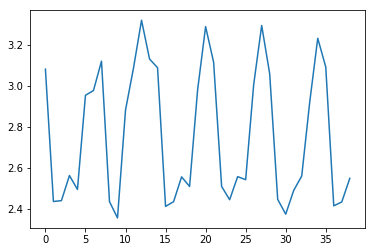

In [27]:
plt.plot(testpreds[129])

In [28]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [29]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.199711   
air_0164b9927d20bcc3_2017-04-23              2.140647   
air_0241aa3964b7f861_2017-04-23              2.282494   
air_0328696196e46f18_2017-04-23              2.240002   
air_034a3d5b40d5b1b1_2017-04-23              3.458756   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   8.022408  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   7.504941  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   8.801098  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   8.393351  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  30.777426

In [30]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [31]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [32]:
submission.to_csv("../submission/3003_conv_run_0.csv.gz",compression='gzip')